In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf

import gpflow
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.base import Parameter
from gpflow.utilities.ops import difference_matrix
from gpflow.kernels.base import Kernel
from gpflow.kernels.stationaries import IsotropicStationary, Stationary

from typing import List, Optional, Union

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import  GridSpec
import matplotlib.dates as dates
from matplotlib.dates import date2num, num2date
from datetime import datetime
dates.set_epoch("1969-01-01T00:00")

import ipywidgets as widgets
from IPython.display import display

%matplotlib nbagg

In [2]:
pd.read_csv("birthdates-1968-1988.csv")

,year,month,day,births,day_of_year,day_of_week
0,1969,1,1,8486,1,3
1,1969,1,2,9002,2,4
2,1969,1,3,9542,3,5
3,1969,1,4,8960,4,6
4,1969,1,5,8390,5,7
...,...,...,...,...,...,...
7300,1988,12,27,11528,362,2
7301,1988,12,28,11847,363,3
7302,1988,12,29,11704,364,4
7303,1988,12,30,11837,365,5


In [3]:
data = pd.read_csv("birthdates-1968-1988.csv")

day_of_week = np.array(data.day_of_week, dtype="float64").reshape(7305, 1)
day_of_year = np.array(data.day_of_year, dtype="float64").reshape(7305, 1)
k = 7
l = 1
for i in range(7500):
    day_of_week = np.append(day_of_week, k)
    day_of_year = np.append(day_of_year, l)
    k += 1
    l += 1
    if k == 8:
        k = 1
    if l == 366:
        l = 1
    
weekends = 1 * np.add(day_of_week == 6, day_of_week == 7) 

weekdays = np.add(day_of_week == 1, day_of_week == 2) 
weekdays = np.add(weekdays, day_of_week == 3)
weekdays = np.add(weekdays, day_of_week == 4)
weekdays = 1 * np.add(weekdays, day_of_week == 5)


Xlist = [i for i in range(1, 7306, 1)]
X = np.array(Xlist, dtype="float64").reshape(7305, 1)

Y = data["births"]
ybar = np.mean(Y)
s = np.std(Y)

Y = np.array((Y - ybar) / s).reshape(7305, 1)

data = (X, Y)
N = len(X)

M = 100
idx = [int(i) for i in list(np.linspace(0, N, M, endpoint=False))]
Z = X[idx, :].copy()

minibatch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

In [4]:
days = np.add(day_of_year == 1, day_of_year == 60)
days = np.add(days, day_of_year == 186)
days = np.add(days, day_of_year == 153)
days = np.add(days, day_of_year == 260)
days = np.add(days, day_of_year == 327)
days = np.add(days, day_of_year == 332)
days = 1 * np.add(days, day_of_year == 360)

In [5]:
class WDaysPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
    
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)

    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        Ix = tf.gather_nd(tf.constant(weekdays), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekdays), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K   

class WEndsPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(weekends), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekends), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

class DayOfYearPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(days), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(days), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

## Modelo

In [6]:
k1 = gpflow.kernels.SquaredExponential(0.2, 260)  # long trend
k2 = gpflow.kernels.SquaredExponential(0.01, 30)  # short trend
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(2, 0.8), 7) * gpflow.kernels.SquaredExponential(0.5, 2000) #
k4 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(0.2, 0.2), 365.25) * gpflow.kernels.SquaredExponential(1, 1000)
k5 = WDaysPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)  # weekday
k6 = WEndsPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)
k7 = DayOfYearPeriodic(gpflow.kernels.SquaredExponential(1, 5000), 365.25)
k8 = gpflow.kernels.SquaredExponential(1, 1200) # 0.005
k9 = gpflow.kernels.White(0.01)

kernel = k1 + k2 + k3 + k4 + k5 + k6 + k7 + k8 + k9
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, whiten=True, num_data=N)

gpflow.set_trainable(m.kernel.kernels[2].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[3].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[4].period, False)
gpflow.set_trainable(m.kernel.kernels[5].period, False)
gpflow.set_trainable(m.kernel.kernels[6].period, False)
gpflow.set_trainable(m.inducing_variable, True)

<IPython.core.display.Javascript object>


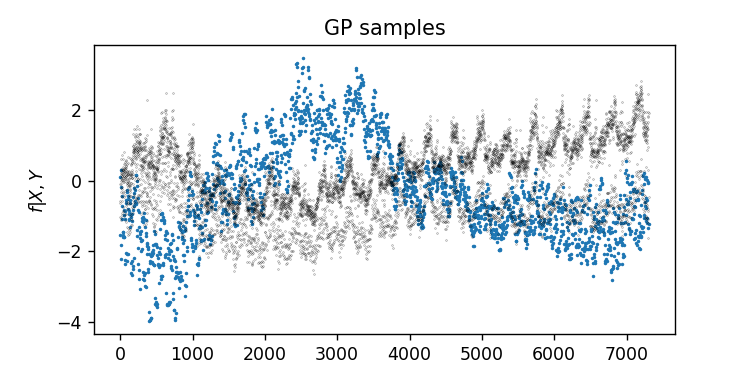

In [7]:
# Genera muestras a priori para testear el kernel

Xt = np.round_(np.linspace(0, 7305, 2000)).astype(np.float64)[:, None]
num_samples = ci_niter(1)
f = m.predict_f_samples(Xt, num_samples)

plt.figure(figsize=(6,3))
for i in range(0, num_samples):
    plt.plot(Xt, f[i, :, :], ".", alpha=1, markersize=2)

plt.plot(X, Y, "k.", alpha=0.5, markersize=0.5)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("GP samples")

plt.show()

In [11]:
def run_adam(model, iterations):
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)  
    optimizer = tf.optimizers.Adam()
    
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            print(step, elbo)
            logf.append(elbo)
    print(step, -training_loss().numpy())
    return logf

In [9]:
maxiter = ci_niter(40000)
logf = run_adam(m, maxiter)

0 -29958.034278178668
10 -26798.359031842585
20 -24328.665189753043
30 -23794.189479843564
40 -22494.675719961866
50 -21524.947713574984
60 -21498.63863181031
70 -19782.578318311633
80 -20483.81687788623
90 -19457.14299453824
100 -18742.891234667648
110 -18983.166511856445
120 -18414.797386395996
130 -18132.451627662456
140 -18103.076979244834
150 -17982.92191081005
160 -18243.26329779481
170 -17395.02440729961
180 -17499.726551579934
190 -17624.631200919197
200 -16784.61310855759
210 -16984.642551240213
220 -16671.18613549381
230 -16329.186247694652
240 -16568.925751296607
250 -15897.459241467055
260 -15963.777883943892
270 -15870.431713564258
280 -15658.383045898338
290 -15908.79639454986
300 -15766.968849192934
310 -15377.756434652427
320 -15730.70066698123
330 -15113.48446879289
340 -15645.629377622317
350 -15033.647746897175
360 -15257.336491729302
370 -15446.890090329785
380 -14948.092562621492
390 -14918.152274515083
400 -14447.376471113508
410 -14669.160744063009
420 -14717.878

3440 -6982.4957698170965
3450 -7078.566146741144
3460 -6975.946251658595
3470 -6881.656357566683
3480 -6892.0140340388325
3490 -7030.124477532952
3500 -7362.048311112296
3510 -6730.305818834924
3520 -6954.985666498537
3530 -7035.703007126051
3540 -6856.095825452081
3550 -6875.470984419098
3560 -6641.847431211852
3570 -6632.974819865445
3580 -6808.66413301707
3590 -6628.297681383397
3600 -6478.530457002315
3610 -6629.675029807973
3620 -6764.7878852591675
3630 -6402.918496777912
3640 -6560.092079810321
3650 -6330.889443399352
3660 -6485.174805355136
3670 -6489.821872660714
3680 -6260.834302875217
3690 -6426.674794278545
3700 -6556.419095689879
3710 -6493.34706419212
3720 -6434.5562941224935
3730 -6129.146992572142
3740 -6598.14274690827
3750 -6313.001812707624
3760 -6196.275824313306
3770 -6198.067137914706
3780 -6576.992876499628
3790 -6295.242619639176
3800 -6449.562753762932
3810 -6629.149689316223
3820 -6384.550873350476
3830 -6555.856826632212
3840 -6183.732463663387
3850 -6262.7929

6830 -2423.894849407762
6840 -2550.727935784096
6850 -2918.4483988541224
6860 -2038.566276804014
6870 -2554.833150364618
6880 -2229.629277271029
6890 -2112.339499204895
6900 -3364.3566871243947
6910 -2655.235734621957
6920 -2587.3088855148644
6930 -3815.1785524706756
6940 -3280.1905769641353
6950 -2066.1941831949994
6960 -2912.8377543190627
6970 -2527.527240866635
6980 -2556.0850950169583
6990 -1829.243582090447
7000 -2125.1828204918143
7010 -2348.576215020119
7020 -2041.6351482896944
7030 -4439.121815292514
7040 -2910.3144716053375
7050 -1902.772280864581
7060 -3424.513661205156
7070 -2972.4081200908695
7080 -2780.0295258562937
7090 -2503.285762353312
7100 -1929.4353367433491
7110 -2622.1471480513364
7120 -2424.960348496981
7130 -2869.788100076123
7140 -3019.030433980493
7150 -2695.6740457405604
7160 -1698.9002109796497
7170 -3061.5619516586603
7180 -1797.5481606830044
7190 -2611.038555463334
7200 -2984.4794783505554
7210 -2824.310336093865
7220 -2057.6210560927598
7230 -2742.87182940

10160 -1888.0351377736336
10170 -2878.5411651382856
10180 -1397.8166694190134
10190 -2154.4419998906365
10200 -1695.4299918771271
10210 -3189.4796220722
10220 -1488.2470273906242
10230 -1756.4656911723682
10240 -2072.3782507412297
10250 -2614.6290796269545
10260 -1793.293765811506
10270 -1523.6745895877102
10280 -1339.911574634119
10290 -2296.287251639551
10300 -1763.9255856079606
10310 -1812.690215445724
10320 -1880.1586113782562
10330 -1801.8439795389472
10340 -1628.1546731136868
10350 -1514.9396157364017
10360 -2402.4504089302977
10370 -1619.3642553667125
10380 -2324.1093822354546
10390 -2630.9788199342347
10400 -2041.1509053105065
10410 -1257.6775561246627
10420 -2236.8162751810855
10430 -3114.115780795261
10440 -1548.8238480952698
10450 -3029.579772253714
10460 -2395.420034422322
10470 -2076.2858826409883
10480 -1997.5545040057566
10490 -1448.814935447882
10500 -3168.9242124937664
10510 -2883.9397581155627
10520 -1922.7585529014195
10530 -4013.9612699139693
10540 -1360.21950259729

13380 -2199.7447759658266
13390 -2417.1074546644372
13400 -3643.748153713237
13410 -2427.6652533943848
13420 -2727.165864589065
13430 -4715.752911763804
13440 -2112.129723878451
13450 -2839.1047606634006
13460 -2089.4637584686625
13470 -2414.4475053124647
13480 -2108.093357704678
13490 -2369.9985626445723
13500 -1907.6264985384514
13510 -2254.291785053009
13520 -1233.3322486550737
13530 -2109.7494875194625
13540 -3586.6978100764613
13550 -1919.8687741734163
13560 -1734.9773268253953
13570 -2478.3538527535643
13580 -2164.528048864833
13590 -1558.1086531711703
13600 -2067.8360153145427
13610 -3150.19972315521
13620 -2403.78639792685
13630 -1453.4793381449142
13640 -2241.3665929214867
13650 -2507.722465677979
13660 -1173.444431437214
13670 -2414.727618836712
13680 -2533.2409147512612
13690 -2718.2288065977555
13700 -2886.363482595337
13710 -2404.522147667555
13720 -1959.073615154577
13730 -1698.7361536432113
13740 -3380.167771913898
13750 -2864.5681112588286
13760 -2090.5403405051034
1377

16600 -1719.644696030132
16610 -709.1043854499328
16620 -1618.2790911105592
16630 -2161.170768355804
16640 -1409.7223175740805
16650 -2340.9756533334307
16660 -2441.4324095484653
16670 -2964.3173014930217
16680 -2691.2966226600597
16690 -1556.3040506567243
16700 -429.18328354435727
16710 -914.2030110786972
16720 -2158.7290198210185
16730 -2878.0272691137225
16740 -2269.135204770582
16750 -2360.566359877044
16760 -3995.802091159576
16770 -2345.893542006914
16780 -1737.689062900114
16790 -1793.4705748598606
16800 -901.6965758702065
16810 -3325.3221122680493
16820 -2345.276685738515
16830 -1773.5137580708374
16840 -1280.3497035144683
16850 -1304.0730610696728
16860 -2148.924405873487
16870 -1568.9799077409548
16880 -2761.926624720498
16890 -2363.265434555018
16900 -1356.5756357110038
16910 -2810.5405274390723
16920 -3167.3563011476012
16930 -1898.7564648964221
16940 -2514.6534347852903
16950 -1135.8950809127123
16960 -1718.8532970753167
16970 -1878.5357251455218
16980 -637.0900526592169
1

19830 -1738.4465419118799
19840 -3652.056033943073
19850 -2838.6861657381087
19860 -2532.2011006690386
19870 -1621.7995069510532
19880 -1219.8956292364792
19890 -1204.1282012057786
19900 -3918.125243945317
19910 -714.8812480535765
19920 -1045.0655181315456
19930 -1437.1972836562172
19940 -2053.0288188878517
19950 -3398.186392543393
19960 -801.1444479863837
19970 -1013.6085380112705
19980 -2590.306909837542
19990 -1942.4213027098826
20000 -958.8098241949386
20010 -1693.116370354341
20020 -2639.6810839760224
20030 -2008.4153103768065
20040 -1427.9943282079082
20050 -1579.562797321985
20060 -1495.007042231746
20070 -2143.6350524368845
20080 -2460.91261311052
20090 -2101.0031168015503
20100 -2737.027152390209
20110 -3377.588041167515
20120 -1706.968485129247
20130 -877.3695984187377
20140 -1609.7612482460695
20150 -345.43723592999777
20160 -2300.845880673127
20170 -1347.2140747888357
20180 -1807.7343280171683
20190 -1950.144837488711
20200 -2382.7755542802306
20210 -2014.6944615661016
2022

23050 -1211.5948999430905
23060 -1079.700696420171
23070 -2195.216754956189
23080 -3455.3907800171182
23090 -1265.0783551207617
23100 -3047.3341804783186
23110 -1945.7127684766926
23120 -2766.1218250704264
23130 -1432.1428624937416
23140 -1408.5192179265737
23150 -1662.0113585416748
23160 -2483.1862177489315
23170 -2118.556533044746
23180 -2828.819810435555
23190 -1631.2056838658352
23200 -1683.8309071730953
23210 -2920.1528237308717
23220 -1353.470017393558
23230 -1025.4171903333108
23240 -1905.3377962065927
23250 -3014.261120133561
23260 -2975.6368422675755
23270 -1889.3563210913344
23280 -1385.7680684537147
23290 -1648.6373760565518
23300 -554.7979373565049
23310 -1121.1292439584147
23320 -2060.5577447838477
23330 -1511.3423490861026
23340 -1163.0204532979171
23350 -2394.121960305373
23360 -1316.7346091860923
23370 -2467.757500098644
23380 -1135.1479581006506
23390 -1002.9552237105831
23400 -1769.537326107247
23410 -2569.9017442009294
23420 -1241.517437886132
23430 -2031.14617998968

26290 -1887.0727107692937
26300 -1722.6599520420964
26310 -3309.462285877698
26320 -1521.8407940181473
26330 -2269.8398658227616
26340 -1772.1456993953152
26350 -1493.5190602905052
26360 -1167.230552827832
26370 -385.798367879687
26380 -2463.5926082785563
26390 -1345.3106492829781
26400 -2117.4674247428634
26410 -3678.6723382710034
26420 -2637.8064492253156
26430 -1301.7019051806758
26440 -1974.175221383642
26450 -1083.8116016651104
26460 -2480.1831424029015
26470 -2248.3216623142453
26480 -1494.1780348278155
26490 -1289.0456854576164
26500 -2204.812335483879
26510 -1767.9245407200358
26520 -1406.0326354863569
26530 -804.4711141306774
26540 -1432.1672113759062
26550 -1351.5296892309343
26560 -2120.8092663212456
26570 -1565.6705575709377
26580 -1513.8302261830497
26590 -3550.502562156059
26600 -1770.1087599624352
26610 -1596.968290032713
26620 -1333.3021186856715
26630 -1093.4770882472221
26640 -652.2328081579778
26650 -2407.6629967987083
26660 -3767.930612017739
26670 -1997.80275357216

29500 -3289.6086349897805
29510 -2897.5411658565995
29520 -1628.6739266325453
29530 -1201.9867322477305
29540 -2804.1694629733206
29550 -2565.9063190359066
29560 -2956.363871619025
29570 -2425.2767373260313
29580 -1749.6386787180343
29590 -1321.6011786141949
29600 -2470.591385890338
29610 -1577.8259560201163
29620 -1001.3114225137417
29630 -2731.142735724496
29640 -1780.0401384458214
29650 -2555.925097855729
29660 -3555.9631800005263
29670 -1450.3310076727478
29680 -2457.435727916649
29690 -1775.8255253225825
29700 -2139.556924119249
29710 -1594.68153273895
29720 -1759.664464013608
29730 -2548.944995226768
29740 -1638.4008061630257
29750 -1576.3562009184666
29760 -2390.8788952534096
29770 -1685.5428237345573
29780 -2464.4683665687703
29790 -2634.5764090692537
29800 -2494.0415451615
29810 -2616.5201648118364
29820 -1665.178387389719
29830 -2479.6853935685954
29840 -1928.35320294973
29850 -1795.4786458495564
29860 -3026.255855071744
29870 -484.5642438383294
29880 -3112.5147770128942
2989

32730 -1128.8028178305758
32740 -2035.6152663643172
32750 -2448.792451016296
32760 -1986.7109944434717
32770 -1930.9572155804592
32780 -2891.761546968698
32790 -1239.440291974824
32800 -1703.9600317538293
32810 -1867.063548946639
32820 -2935.527704447951
32830 -3230.8764736353705
32840 -1805.2385205491416
32850 -1198.0409350238147
32860 -2084.930645684943
32870 -2348.2131657161112
32880 -2355.26667797061
32890 -261.7501040460889
32900 -1626.218234414432
32910 -1524.8581984234092
32920 -1454.3392817599513
32930 -1595.494824762615
32940 -2089.5018235368507
32950 -1927.0444828147529
32960 -1561.3739579407425
32970 -2250.6950105822625
32980 -2468.2805032084643
32990 -918.312108590571
33000 -2612.8495742847967
33010 -364.1274664866971
33020 -2067.523827488331
33030 -1743.4216100446079
33040 -1977.7905497984298
33050 -1859.1659543767096
33060 -1372.9734866399115
33070 -668.9176631085201
33080 -898.2865673083718
33090 -1440.9892903341508
33100 -2221.7008749650117
33110 -1865.791224730556
3312

35970 -2311.735004309137
35980 -3263.736897015961
35990 -1768.336792497976
36000 -1526.2283523521392
36010 -2790.822679479522
36020 -1118.139073704223
36030 -2624.4803988322774
36040 -1594.6999680546294
36050 -1074.6671978980644
36060 -3768.6858953649366
36070 -2436.773779439988
36080 -792.3151608889735
36090 -2093.7298045729985
36100 -610.2532398778349
36110 -1600.6914457508556
36120 -587.5183572542405
36130 -1704.4650394608423
36140 -1516.8332776101465
36150 -1876.2096756751398
36160 -2310.8042035367725
36170 -2365.8778921900825
36180 -2512.5843353332016
36190 -1140.0335996821516
36200 -790.929298976218
36210 -2885.8743248558126
36220 -1234.9029425200195
36230 -1931.4365299921487
36240 -1124.9096521904953
36250 -1592.2400272200673
36260 -3294.2405975715933
36270 -2654.6498143604053
36280 -2364.85159934404
36290 -1288.7515758415666
36300 -1722.9486510509687
36310 -2054.150674254574
36320 -1080.739049901214
36330 -2846.7973253862597
36340 -1922.1900585367894
36350 -829.4154028404786
36

39180 -2588.8269049036085
39190 -2046.1517205930395
39200 -2924.2207425943143
39210 -989.7169806619011
39220 -1062.4780523897364
39230 -1937.6700643959275
39240 -2189.730629735874
39250 -1728.5965287210854
39260 -3835.6952457588204
39270 -1881.1830771446969
39280 -1306.7872698470599
39290 -2389.354750626957
39300 -848.4248776167465
39310 -2555.833526232996
39320 -955.2021493740772
39330 -2512.70548658146
39340 -826.8836359654068
39350 -2974.9477652761334
39360 -1088.6511046687156
39370 -853.1935668738339
39380 -2032.423439857923
39390 -1386.2058782706206
39400 -1928.6218378775952
39410 -2444.209748091493
39420 -3063.7202614315543
39430 -2045.7216923608244
39440 -2200.8501331864527
39450 -1435.8853859906242
39460 -1797.5057532658852
39470 -477.1630893929316
39480 -1905.6338615422164
39490 -2852.2940249383996
39500 -470.97509874876414
39510 -2042.4634873611997
39520 -1047.0177605239344
39530 -1195.3924405528173
39540 -4262.194165839317
39550 -587.2839534095606
39560 -704.4879630983925
39

<IPython.core.display.Javascript object>


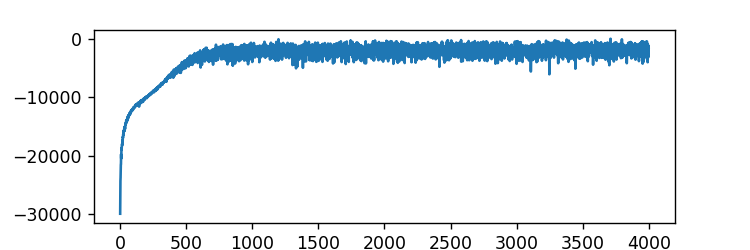

In [10]:
fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(logf)
plt.show()

In [12]:
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.05419243079365552
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,264.66634763332434
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.804366462105122e-08
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,43.2028718597935
SVGP.kernel.kernels[2].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.860720785332251
SVGP.kernel.kernels[2].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6615000781406576
SVGP.kernel.kernels[2].kernels[0].period,Parameter,Softplus,,False,(),float64,6.999999999999999
SVGP.kernel.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.43838282689633057
SVGP.kernel.kernels[2].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2011.614212784457
SVGP.kernel.kernels[3].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.33495662770713813


In [13]:
data = pd.read_csv("birthdates-1968-1988.csv")
Xd = num2date(data.index.values)

## Figuras

In [15]:
f = m.predict_f_samples(Xt, full_cov=True, num_samples=10)

<IPython.core.display.Javascript object>


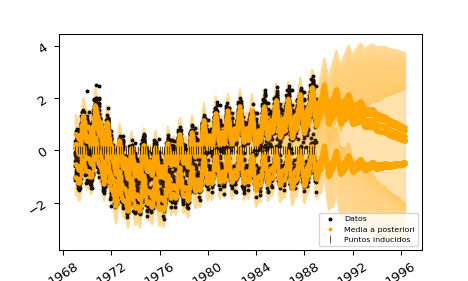

interactive(children=(FloatSlider(value=1.0, description='data alpha:', max=1.0), FloatSlider(value=4.0, descr…

In [16]:
n = 10001
Xt = np.round_(np.linspace(0, 10000, n)).astype(np.float64)[:, None]
mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

fig, ax = plt.subplots(1, figsize=(5, 3))
plt.title('Predicciones después de entrenar el modelo', fontsize=8)

def update_plot(da, ds, ms, ma, fa, fw):
    np.random.seed(0)
    ax.cla()
    ax.tick_params(labelrotation=33)
    ax.plot_date(Xd, Y, '.', label='Datos', alpha=da, markersize=ds, color='k')
    (mean,) = ax.plot(Xt[:-1], mpostc, '.', color='orange', markersize=ms, alpha=ma, label='Media a posteriori')
    col = mean.get_color()
    ax.plot(Xt[:-1, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col)
    ax.plot(Xt[:-1, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col) 
    
    ax.fill_between(Xt[:-1, 0],
                    (mpostc - 2 * spostc ** 0.5)[:, 0],
                    (mpostc + 2 * spostc ** 0.5)[:, 0],
                    color = col,
                    alpha = fa, 
                    lw = fw)
    
    
#     for i in range(0, 30):  #'num_samples'
#         ax.plot(Xt[:-1] , f[i, 1:, :], 'b-', alpha=0.15, lw=1.5)
        
    ax.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
    ax.legend(loc='lower right', fontsize=6)
    



da = widgets.FloatSlider(min=0, max=1, value=1, description='data alpha:')
ds = widgets.FloatSlider(min=0, max=4, value=4, description='data size:')
ms = widgets.FloatSlider(min=0, max=4, value=4, description='mean size:')
ma = widgets.FloatSlider(min=0, max=1, value=1, description='mean alpha:')
fw = widgets.FloatSlider(min=0, max=4, value=0.5, description='fill size:')
fa = widgets.FloatSlider(min=0, max=1, value=0.33, description='fill alpha:')


widgets.interactive(update_plot, 
                    da=da, 
                    ds=ds,
                    ms=ms, 
                    ma=ma, 
                    fa=fa, 
                    fw=fw)

<IPython.core.display.Javascript object>


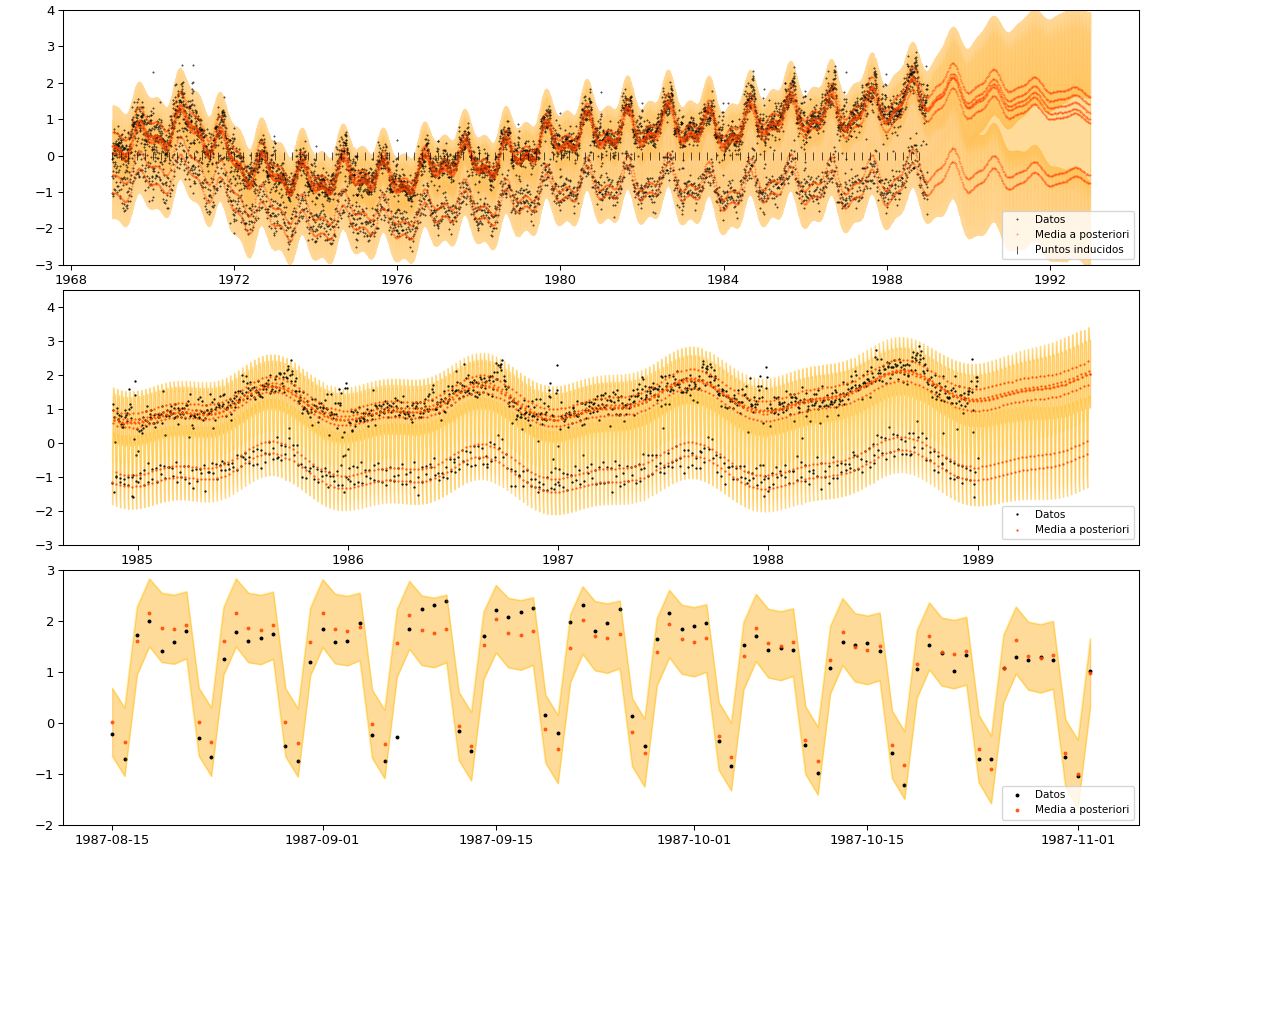

(-2.0, 3.0)

In [17]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(nrows=3, ncols=1, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.05, hspace=0.1)

fig = plt.figure(0, figsize=(13.5, 11))
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0])

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, '.', label='Datos', alpha=1, markersize=0.8, color='k')
(mean,) = ax1.plot(Xt, mpostc, '.', color='orangered', markersize=0.7, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
# ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(-3,4)

k, t = 1700, 5800
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=1.5, color='k')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=1.5, alpha=0.9, label='Media a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax2.set_yticks([])
ax2.legend(loc='lower right', fontsize=8)
ax2.set_ylim(-3,4.5)

k, t = 80,6800
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=4, color='k')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=4, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax3.set_yticks([])
ax3.legend(loc='lower right', fontsize=8)
ax3.set_ylim(-2,3)

#fig.savefig('model.png', dpi=200) 

In [15]:
from matplotlib.ticker import FormatStrFormatter

In [16]:
logf2 = [i / 1000 for i in logf]

<IPython.core.display.Javascript object>


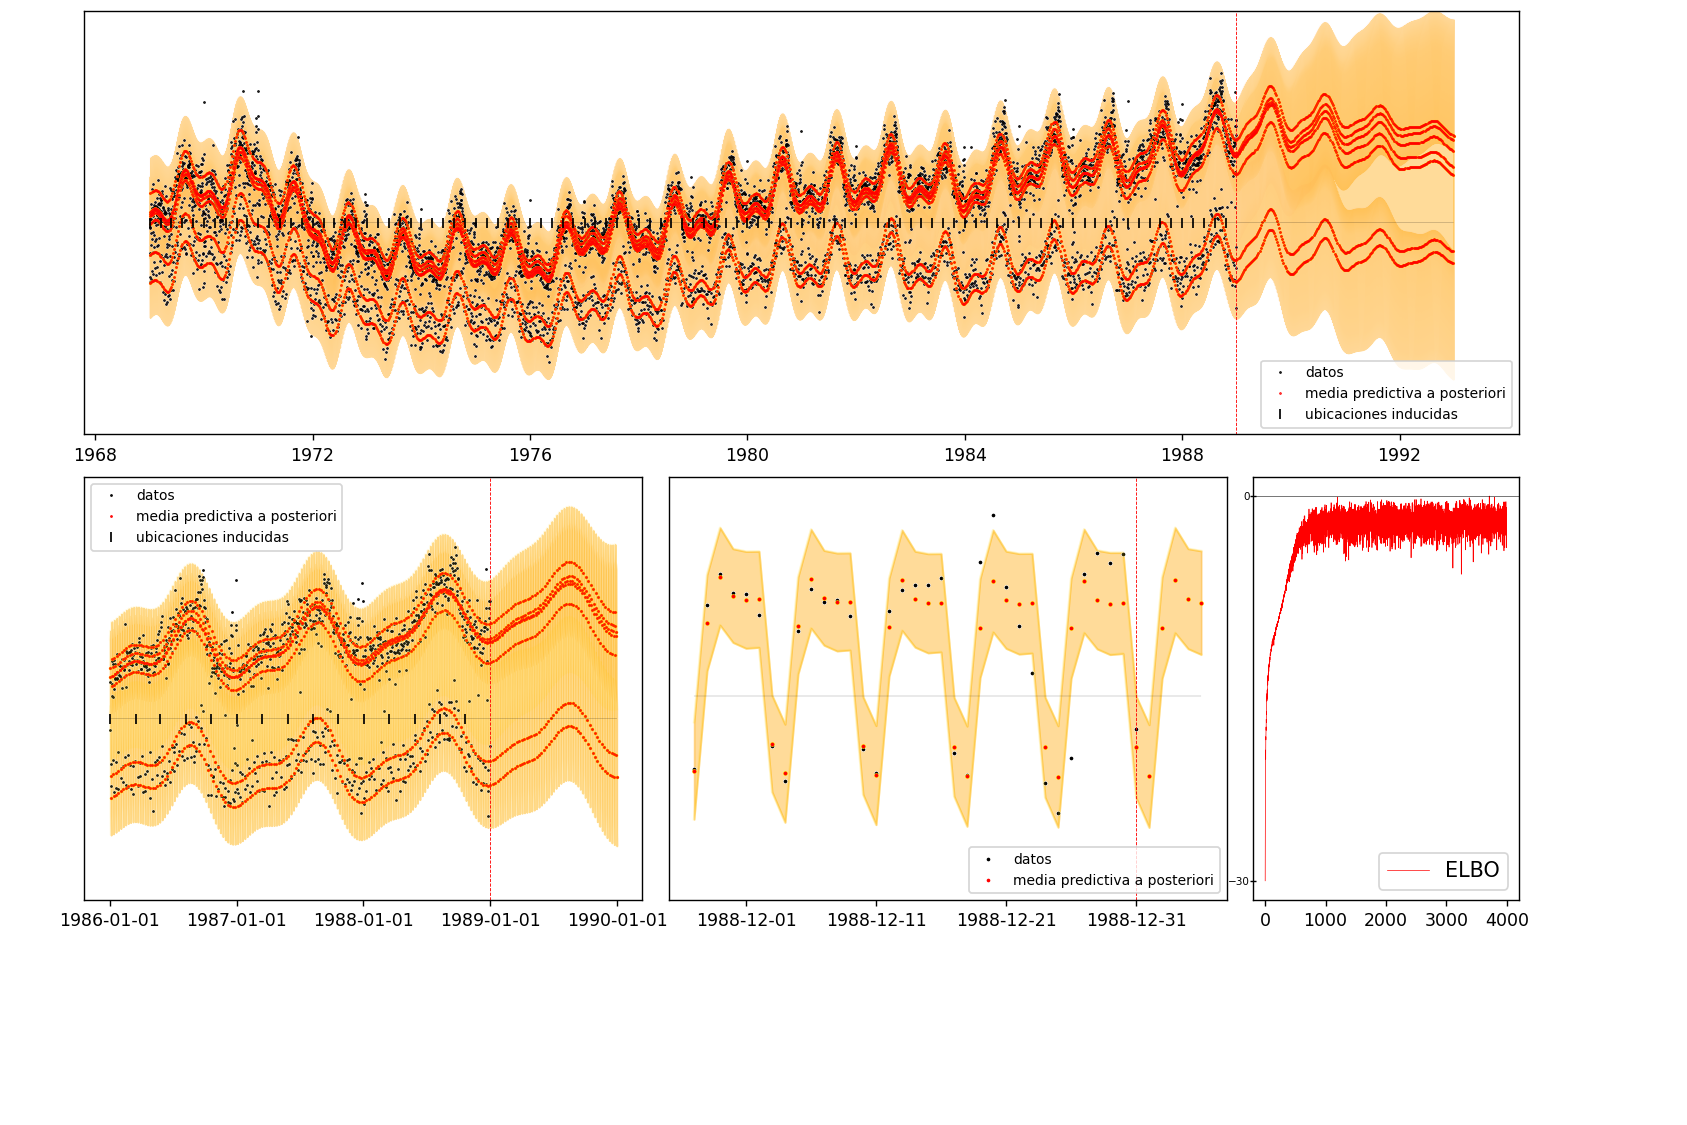

In [93]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(2, 5, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.1, hspace=0.1, 
                width_ratios=[0.2, 0.2, 0.2, 0.2, 0.2])

fig = plt.figure(0, figsize=(13.5, 9))
#fig = plt.figure(0, figsize=(8, 5))

ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :2])
ax3 = fig.add_subplot(grid[1, 2:4])
ax4 = fig.add_subplot(grid[1, 4])

locator = dates.YearLocator()

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, 'o', alpha=1, markersize=1, color='w')
ax1.plot_date(Xd, Y, 'o', label='datos', alpha=1, markersize=0.55, color='k')
(mean,) = ax1.plot(Xt, mpostc, 'o', color='gold', markersize=0.8, alpha=1)
(mean,) = ax1.plot(Xt, mpostc, 'o', color='red', markersize=0.5, alpha=1, label='media predictiva a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'k|', mew=1, label='ubicaciones inducidas')
ax1.plot(Xt, np.zeros_like(Xt), 'k-', lw=0.1)
ax1.legend(loc='lower right', fontsize=8)
ax1.axvline(x=7304, ymin=-1, ymax=1, ls='--', lw=0.5, color='red')
ax1.set_ylim(-4,4)




#k, t = 1700, 5800 #fig1
k, t = 1460, 6210
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], 'o', alpha=1, markersize=1.1, color='w')
ax2.plot_date(Xd[t:k+t], Y[t:k+t], 'o', label='datos', alpha=1, markersize=0.6, color='k')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], 'o', color='gold', markersize=1, alpha=1)
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], 'o', color='red', markersize=0.6, alpha=1, label='media predictiva a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
ax2.set_xticks(['1986','1987','1988','1989','1990'])
ax2.set_yticks([])
ax2.plot(Z[85:], np.zeros_like(Z[85:]), 'k|', mew=1, label='ubicaciones inducidas')
ax2.plot(Xt[t:k+t,0], np.zeros_like(Xt[t:k+t,0]), 'k-', lw=0.1)
ax2.legend(loc='upper left', fontsize=8)
ax2.axvline(x=7304, ymin=0, ymax=1, ls='--', lw=0.5, color='red')
ax2.set_ylim(-3,4)

k, t = 40,7270
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], 'o', alpha=1, markersize=1.7, color='w')
ax3.plot_date(Xd[t:k+t], Y[t:k+t], 'o', label='datos', alpha=1, markersize=1.1, color='k')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], 'o', color='gold', markersize=1.7, alpha=1)
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], 'o', color='red', markersize=1.1, alpha=1, label='media predictiva a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
ax3.plot(Xt[t:k+t,0], np.zeros_like(Xt[t:k+t,0]), 'k-', lw=0.1)
ax3.set_yticks([])
ax3.set_xticks(['1988-12-01', '1988-12-11', '1988-12-21', '1988-12-31'])
ax3.legend(loc='lower right', fontsize=8)
ax3.axvline(x=7304, ymin=0, ymax=1, ls='--', lw=0.5, color='red')
ax3.set_ylim(-2.8,3)

ax4.plot(logf2[:4000], color='r', lw=0.4, label='ELBO')
ax4.axhline(0, ls='-', lw=0.3, color='k')#
ax4.set_yticks([-30, 0])
# ax4.yaxis.set_major_formatter(FormatStrFormatter('%2i'))
ax4.tick_params(axis='y', labelleft=True, labelright=False, left=True, pad=0.2, direction='inout', labelsize=6)
ax4.legend(loc='lower right', fontsize=12) 
fig.savefig('500dpi.png', dpi=500)